# Load data from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls "/content/drive/My Drive/Zindi_dataset"

client_test.csv   invoice_test.csv   SampleSubmission.csv
client_train.csv  invoice_train.csv


# FRAUD DETECTION

This notebook should help you get started with any competition on Zindi. In it we cover:
- Loading the data
- Simple EDA and an example of feature enginnering

In [3]:
!pip install catboost

# Setup

Load the data into the notebook.

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm

##Supress warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
    
# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

# ensembles
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

# boosting 
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, confusion_matrix, recall_score,precision_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load the client training dataset

In [5]:
client_train = pd.read_csv('/content/drive/My Drive/Zindi_dataset/client_train.csv')
client_train.head(5)

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


.
.

## Check the shape of the client  training dataset

In [6]:
client_train.shape

(135493, 6)

## Load the client testing dataset

In [7]:
client_test = pd.read_csv('/content/drive/My Drive/Zindi_dataset/client_test.csv')
client_test['client_id']

0           test_Client_0
1           test_Client_1
2          test_Client_10
3         test_Client_100
4        test_Client_1000
               ...       
58064    test_Client_9995
58065    test_Client_9996
58066    test_Client_9997
58067    test_Client_9998
58068    test_Client_9999
Name: client_id, Length: 58069, dtype: object

.
.

## Check the shape of the client  training dataset

In [8]:
client_test.shape

(58069, 5)

.
## Load the invoice training dataset

In [9]:
invoice_train = pd.read_csv('/content/drive/My Drive/Zindi_dataset/invoice_train.csv')
invoice_train.head(5)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


.
.
## Check the shape of the invoice training dataset

In [10]:
invoice_train.shape

(4476749, 16)

.
.
## Load the invoice testing dataset

In [11]:
invoice_test = pd.read_csv('/content/drive/My Drive/Zindi_dataset/invoice_test.csv')
invoice_test.head(5)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,test_Client_0,2018-03-16,11,651208,0,203,8,1,755,0,0,0,19145,19900,8,ELEC
1,test_Client_0,2014-03-21,11,651208,0,203,8,1,1067,0,0,0,13725,14792,8,ELEC
2,test_Client_0,2014-07-17,11,651208,0,203,8,1,0,0,0,0,14792,14792,4,ELEC
3,test_Client_0,2015-07-13,11,651208,0,203,9,1,410,0,0,0,16122,16532,4,ELEC
4,test_Client_0,2016-07-19,11,651208,0,203,9,1,412,0,0,0,17471,17883,4,ELEC


.
.
## Check the shape of the invoice testing dataset

In [12]:
invoice_test.shape

(1939730, 16)

## Take a look at the sample submission

In [13]:
SampleSubmission = pd.read_csv('/content/drive/My Drive/Zindi_dataset/SampleSubmission.csv')
SampleSubmission.head(5)

,client_id,target
0,test_Client_0,0.957281
1,test_Client_1,0.996425
2,test_Client_10,0.612359
3,test_Client_100,0.776933
4,test_Client_1000,0.571046




# Missing values
Let's check if there's any missing values in our data.

In [14]:
client_train.isnull().sum() 

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [15]:
client_test.isnull().sum() 

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
dtype: int64

In [16]:
invoice_train.isnull().sum() 

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [17]:
invoice_test.isnull().sum() 

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

# Combining the data sets

In [18]:
new_df = invoice_train.merge(client_train, left_on='client_id', right_on='client_id',
          suffixes=('', None))
new_df_test = invoice_test.merge(client_test, left_on='client_id', right_on='client_id',
          suffixes=('', None))

# Drop duplicates
new_df = new_df.drop_duplicates(subset=["client_id"])
new_df_test = new_df_test.drop_duplicates(subset=["client_id"])
new_df['client_id']

0              train_Client_0
35             train_Client_1
72            train_Client_10
90           train_Client_100
110         train_Client_1000
                  ...        
4476596    train_Client_99995
4476667    train_Client_99996
4476708    train_Client_99997
4476744    train_Client_99998
4476746    train_Client_99999
Name: client_id, Length: 135493, dtype: object

In [19]:
new_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58069 entries, 0 to 1939697
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   client_id             58069 non-null  object
 1   invoice_date          58069 non-null  object
 2   tarif_type            58069 non-null  int64 
 3   counter_number        58069 non-null  int64 
 4   counter_statue        58069 non-null  int64 
 5   counter_code          58069 non-null  int64 
 6   reading_remarque      58069 non-null  int64 
 7   counter_coefficient   58069 non-null  int64 
 8   consommation_level_1  58069 non-null  int64 
 9   consommation_level_2  58069 non-null  int64 
 10  consommation_level_3  58069 non-null  int64 
 11  consommation_level_4  58069 non-null  int64 
 12  old_index             58069 non-null  int64 
 13  new_index             58069 non-null  int64 
 14  months_number         58069 non-null  int64 
 15  counter_type          58069 non-nu

In [20]:
new_df.columns

Index(['client_id', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type', 'disrict', 'client_catg',
       'region', 'creation_date', 'target'],
      dtype='object')

## Check for NaN values to make sure everything went well

In [21]:
new_df.isna().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
disrict                 0
client_catg             0
region                  0
creation_date           0
target                  0
dtype: int64

# .
# EDA + Feature Engineering

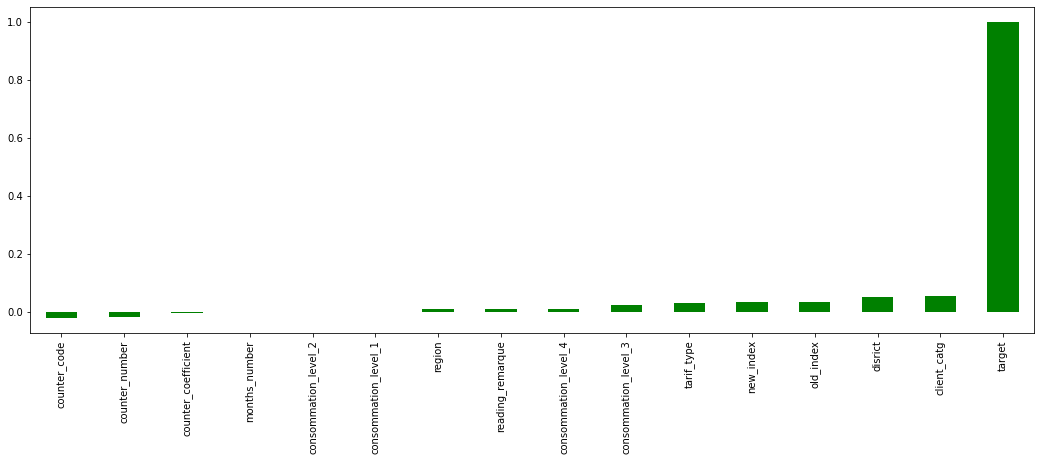

In [22]:
# Look at correlation with target
new_df.corr()['target'].sort_values().plot(kind='bar', color ='g', figsize=(18, 6))


.


## Take a look at the correlation between the variables

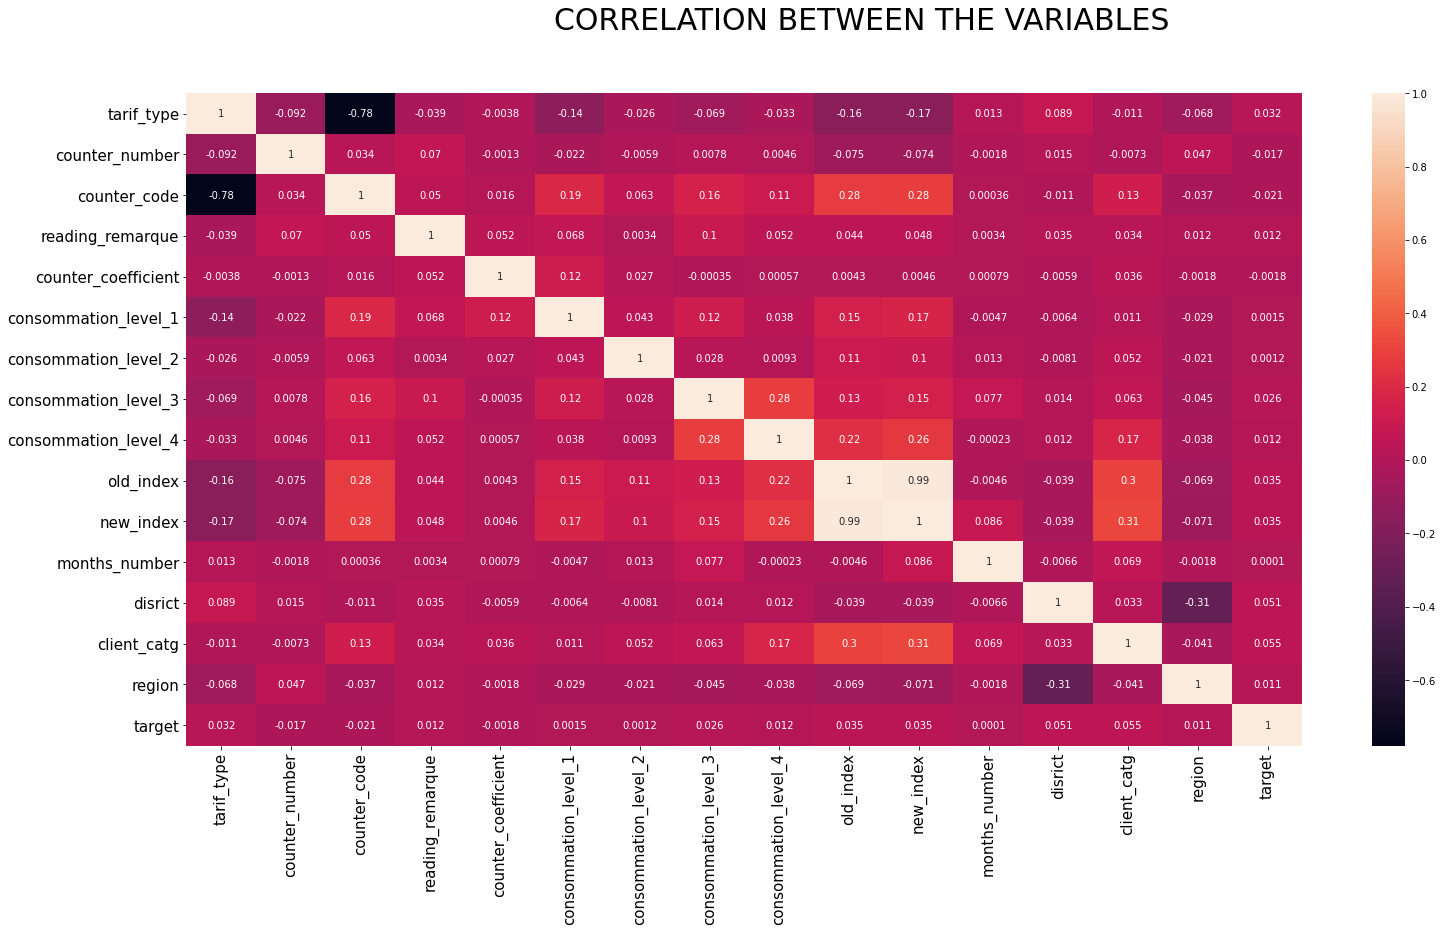

In [23]:
Correlation  = new_df.corr(method = 'pearson')

plt.figure(figsize=(25,12))
sns.heatmap(Correlation, annot=True)
plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.suptitle("CORRELATION BETWEEN THE VARIABLES", fontsize = 30)
plt.show()

From the correlation heatmap, we observe that the avariables (old index and new index) are strongly correlated.Putting features that are highly correlated to a model brings the problem of collinearity and could lower the performance of a model. You can decide to train one model with all the features, and then another with only the poorly correlated features and compare their accuracy.

In [24]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135493 entries, 0 to 4476746
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             135493 non-null  object 
 1   invoice_date          135493 non-null  object 
 2   tarif_type            135493 non-null  int64  
 3   counter_number        135493 non-null  int64  
 4   counter_statue        135493 non-null  object 
 5   counter_code          135493 non-null  int64  
 6   reading_remarque      135493 non-null  int64  
 7   counter_coefficient   135493 non-null  int64  
 8   consommation_level_1  135493 non-null  int64  
 9   consommation_level_2  135493 non-null  int64  
 10  consommation_level_3  135493 non-null  int64  
 11  consommation_level_4  135493 non-null  int64  
 12  old_index             135493 non-null  int64  
 13  new_index             135493 non-null  int64  
 14  months_number         135493 non-null  int64  
 15 

## Simple Feature engineering

#### Trend of of electricty fraud, based off of the month of joining 

<Figure size 1440x1080 with 0 Axes>

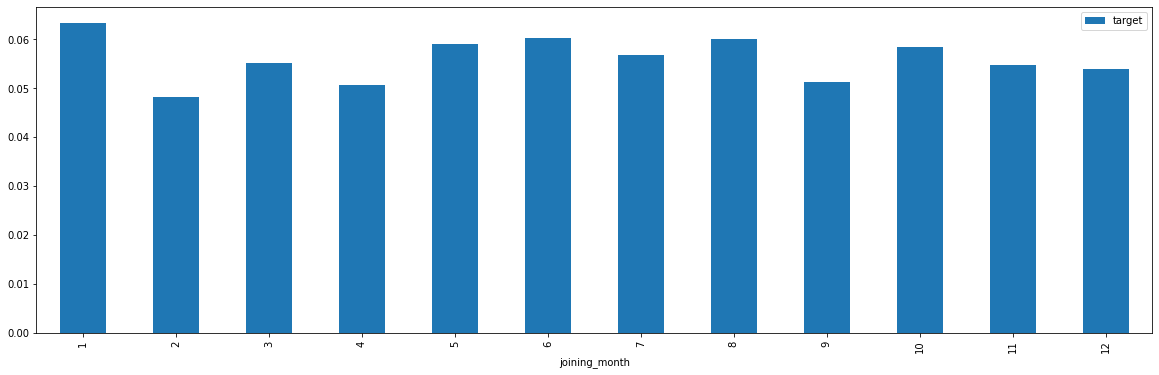

In [25]:

new_df['creation_date'] = pd.to_datetime(new_df['creation_date'])
new_df_test['creation_date'] = pd.to_datetime(new_df_test['creation_date'])

# Date variables
new_df_test['joining_month'] = new_df_test['creation_date'].dt.month
new_df_test['joining_year'] = new_df_test['creation_date'].dt.year

new_df['joining_month'] = new_df['creation_date'].dt.month
new_df['joining_year'] = new_df['creation_date'].dt.year


plt.figure(figsize = (20, 15))
new_df.groupby('joining_month').mean().reset_index().plot(y='target', x='joining_month', kind='bar', figsize = (20,6))

In [26]:
new_df

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target,joining_month,joining_year
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC,60,11,101,1994-12-31,0.0,12,1994
35,train_Client_1,2010-09-02,11,678902,0,203,8,1,388,0,0,0,11429,11817,2,ELEC,69,11,107,2002-05-29,0.0,5,2002
72,train_Client_10,2010-02-15,11,572765,0,203,8,1,407,0,0,0,31955,32362,4,ELEC,62,11,301,1986-03-13,0.0,3,1986
90,train_Client_100,2009-10-22,11,2078,0,413,6,1,0,0,0,0,98,98,4,ELEC,69,11,105,1996-11-07,0.0,11,1996
110,train_Client_1000,2015-02-13,11,19575,0,207,9,1,800,159,0,0,0,959,4,ELEC,62,11,303,2014-10-14,0.0,10,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476596,train_Client_99995,2005-07-10,11,897286,0,207,6,1,0,0,0,0,14,14,4,ELEC,62,11,304,2004-07-26,0.0,7,2004
4476667,train_Client_99996,2015-10-20,11,398783,0,207,9,1,605,0,0,0,895,1500,4,ELEC,63,11,311,2012-10-25,0.0,10,2012
4476708,train_Client_99997,2015-08-06,11,262195,0,207,9,1,280,0,0,0,3573,3853,4,ELEC,63,11,311,2011-11-22,0.0,11,2011
4476744,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,0,0,3197,3732,8,ELEC,60,11,101,1993-12-22,0.0,12,1993


## Trend of of electricty fraud, based off of the year of joining 

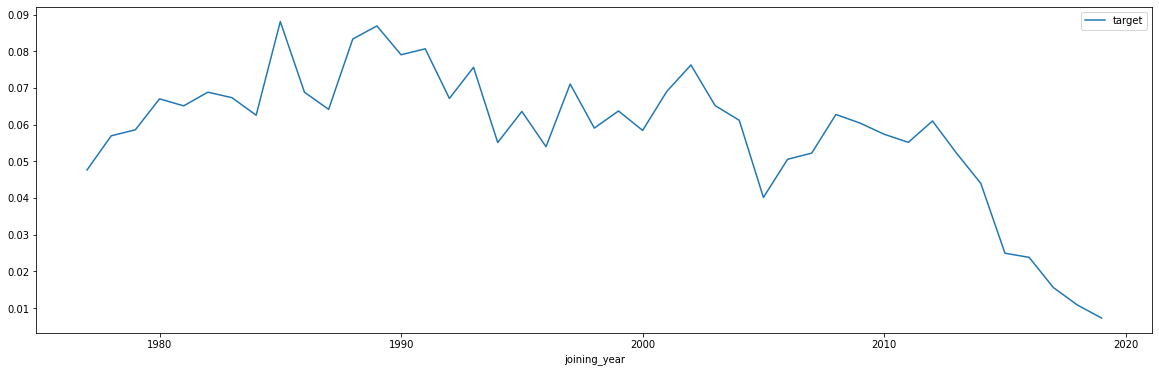

In [27]:
new_df.groupby('joining_year').mean().reset_index().plot(y='target', x='joining_year',figsize = (20,6))

## You can do more!!!

You can continue to look at different features and make visualizations that would allow yoiu to better understand the data

# Model Evaluation

Let us summarize our data



In [28]:
new_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tarif_type,135493.0,1.717926e+01,1.191659e+01,8.0,11.0,11.0,11.0,4.500000e+01
counter_number,135493.0,6.935480e+11,3.928191e+12,0.0,139751.0,526861.0,1201665.0,2.739110e+13
counter_code,135493.0,1.994262e+02,1.284661e+02,0.0,202.0,203.0,207.0,6.000000e+02
reading_remarque,135493.0,7.393201e+00,1.845631e+00,6.0,6.0,8.0,9.0,4.130000e+02
counter_coefficient,135493.0,1.001638e+00,2.232275e-01,0.0,1.0,1.0,1.0,5.000000e+01
consommation_level_1,135493.0,4.311685e+02,8.717099e+02,0.0,65.0,275.0,608.0,9.992000e+04
consommation_level_2,135493.0,1.201788e+02,2.417318e+03,0.0,0.0,0.0,0.0,7.857570e+05
consommation_level_3,135493.0,2.781331e+01,2.084783e+02,0.0,0.0,0.0,0.0,4.079800e+04
consommation_level_4,135493.0,7.468753e+01,1.169659e+03,0.0,0.0,0.0,0.0,1.235320e+05
old_index,135493.0,1.435281e+04,3.108792e+04,0.0,993.0,5644.0,18153.0,1.551151e+06


From this, we can see that index, counter_number, new_index and joining year have more outliers

In [29]:
new_df['target'].value_counts() *100/len(new_df)

0.0    94.415948
1.0     5.584052
Name: target, dtype: float64

We can see from the dataset that the 0s are more thus our data will be more biased when modelling

In [30]:
new_df = new_df.reset_index()

y_train = new_df['target']
X_train = new_df[['tarif_type', 'counter_number',
        'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index',  'disrict', 'client_catg',
       'region', 'joining_month', 'joining_year']]



X_test = new_df_test[['tarif_type', 'counter_number',
        'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'disrict', 'client_catg',
       'region', 'joining_month', 'joining_year']]


Define our Evaluation model

In [31]:
def evaluate_model(model,X,y):
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3, random_state =1)
    scores = cross_val_score(model,X,y,scoring='accuracy',cv=cv,n_jobs=-1,error_score='raise')
    return scores

In [32]:
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

forward_regression(X_train,y_train,0.05)

['client_catg',
 'joining_year',
 'disrict',
 'region',
 'tarif_type',
 'consommation_level_3',
 'reading_remarque',
 'old_index',
 'joining_month',
 'counter_code']

The variables chosen can be seen to exclude the ones noted earlier to have outliers

## Let's use the chosen variables by the forward regression model

In [33]:
X_train = new_df[['client_catg',
 'joining_year',
 'disrict',
 'region',
 'tarif_type',
 'consommation_level_3',
 'reading_remarque',
 'old_index',
 'joining_month',
 'counter_code']
]
X_test = new_df_test[['client_catg',
 'joining_year',
 'disrict',
 'region',
 'tarif_type',
 'consommation_level_3',
 'reading_remarque',
 'old_index',
 'joining_month',
 'counter_code']
]

Fill all Nans

In [34]:
X_train.isnull().any()
X_train = X_train.fillna(method='ffill')

y_train.isnull().any()
y_train = y_train.fillna(method='ffill')

In [35]:
# Logistic Regression 
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.33,random_state=42)

logisticRegr = LogisticRegression(max_iter = 100000,solver = 'lbfgs',class_weight = 'balanced')
logisticRegr.fit(X_train_split,y_train_split)

y_preds = logisticRegr.predict_proba(X_test)[:,0]

print("Accuracy using crossval " , np.mean(evaluate_model(logisticRegr, X_train,y_train)))
score = logisticRegr.score(X_train,y_train)


logisticRegr_split = LogisticRegression().fit(X_train_split,y_train_split)
y_pred_split = logisticRegr.predict(X_test_split)

score_split = logisticRegr.score(X_test_split,y_test_split)
print("Accuracy using splitted datasets : ", score_split)

# conf_matrix
cf_matrix = confusion_matrix(y_test_split,y_pred_split)
print("Confusion Matrix\n : ", cf_matrix)

# recall --> TP / (TP + FN) 
recall = recall_score(y_test_split,y_pred_split)
print("Recall \n : ", recall)

# precision --> TP / (TP + FP) 
precision = precision_score(y_test_split,y_pred_split)
print("Precision \n : ", precision)

Accuracy using crossval  0.5966162683901545
Accuracy using splitted datasets :  0.6088609576633194
Confusion Matrix
 :  [[25731 16431]
 [ 1058  1493]]
Recall 
 :  0.5852606820854567
Precision 
 :  0.08329613925463067


In [ ]:
y_pred_s plit

The recall is intuitively the ability of the classifier to find all the positive samples.

The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


### create our csv submission

In [36]:

si = pd.DataFrame()
si['client_id'] = new_df_test['client_id']
si['target'] = y_preds
si.to_csv('logt.csv',index=False)
si.tail(5)

,client_id,target
1939587,test_Client_9995,0.446697
1939591,test_Client_9996,0.435258
1939637,test_Client_9997,0.610374
1939696,test_Client_9998,0.602958
1939697,test_Client_9999,0.441461


### Let's try other models

In [37]:

# create array of models to evaluate
models = []
models.append(('LoR',LogisticRegression()))
models.append(('Dec_Tree',DecisionTreeClassifier(max_depth=5, random_state=0)))
models.append(('KNN',KNeighborsClassifier(n_neighbors = 10)))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('GaussianNB',GaussianNB()))
# models.append(('SVM',SVC()))
# models.append(('R_Forest',RandomForestClassifier(n_estimators = 190, random_state=0)))


files = []
names = []
list_of_lists = []
predictions =[]
scores = []

for name,model in models:
    model.fit(X_train,y_train)
    
    pred_name = "y" + name
    
    pred_name = model.predict(X_test)
    
    # print(name, " Accuracy: " ,np.mean(evaluate_model(model,X_test,pred_name)))
    print(name," Accuracy :", np.mean(evaluate_model(model,X_train,y_train)))
    ss = pd.DataFrame()
    ss['client_id'] = new_df_test['client_id']
    ss['target'] = pred_name 
    ss.to_csv(name + ".csv",index=False)


LoR  Accuracy : 0.9440758319060054
Dec_Tree  Accuracy : 0.9441250351214859
KNN  Accuracy : 0.9441471766138433
LDA  Accuracy : 0.9434386523081408
GaussianNB  Accuracy : 0.932618895636148


# Let's split our dataset into train and test our models with test and train splits

In [38]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.33,random_state=42)

In [39]:
scaler = StandardScaler()
scaler.fit(X_train_split)
scaler.transform(X_train_split)
# Repeat same thing now evaluating our models
models_splits = []
models_splits.append(('LoR_split',LogisticRegression(random_state=0,max_iter = 1000)))
models_splits.append(('Dec_Tree_split',DecisionTreeClassifier(max_depth=5, random_state=0)))
models_splits.append(('KNN_split',KNeighborsClassifier(n_neighbors = 10)))
models_splits.append(('LDA_split',LinearDiscriminantAnalysis()))
models_splits.append(('GaussianNB_split',GaussianNB()))
models_splits.append(('Catb',CatBoostClassifier(border_count = 35, depth =10, iterations= 100, learning_rate = 0.1,metric_period=100)))

for name, model in models_splits:
    model.fit(X_train_split,y_train_split)
    
    # pred_name = "y" + name
    
    predicted_val = model.predict(X_test_split)
    
    # evaluate model
   
    print(name," MAE :", mean_absolute_error(y_test_split,predicted_val))
  
    # print(name," Model Accuracy : ", np.mean(evaluate_model(model,X_test_split,y_test_split)))
    # print(name," Model Accuracy split : ", np.mean(evaluate_model(model,X_train_split,y_train_split)))

    predicted_val = []

  

LoR_split  MAE : 0.057119853286516226
Dec_Tree_split  MAE : 0.05716458300717912
KNN_split  MAE : 0.057119853286516226
LDA_split  MAE : 0.057656609934470957
GaussianNB_split  MAE : 0.08015565942790687
0:	learn: 0.6181552	total: 95.9ms	remaining: 9.49s
99:	learn: 0.1896891	total: 3.3s	remaining: 0us
Catb  MAE : 0.057119853286516226


# Let's use boosting ensemble with Catboost

In [40]:
model = CatBoostClassifier(iterations = 1000,learning_rate = 1, depth = 2,metric_period=1000)
model = model.fit(X_train,y_train)
pred_y = model.predict(X_test)

# create submission_csv
ss_boost = pd.DataFrame()
ss_boost['client_id'] = new_df_test['client_id']
ss_boost['target'] = pred_y
ss_boost.to_csv("cat_before_estimation" + ".csv",index=False)

print("Catboost"," Model Accuracy before estimating parameters: ", np.mean(evaluate_model(model,X_test_split,y_test_split)))


0:	learn: 0.2145930	total: 51.6ms	remaining: 51.6s
999:	learn: 0.1901404	total: 32.2s	remaining: 0us
Catboost  Model Accuracy before estimating parameters:  0.9405616724062988


## Estimating Parameters for CatBoost Model using GridSearch



In [41]:
from sklearn.model_selection import GridSearchCV

parameters = {'depth'         : [10],
                 'learning_rate' : [0.1],
                 'iterations'    : [100],
           'border_count':[35, 40, 45, 50, 55],
                }
                
model = CatBoostClassifier(iterations = 1000,learning_rate = 1, depth = 2,metric_period=1000)
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)   

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")   
  
print("\n The best estimator across ALL searched params:\n",
         grid.best_estimator_)
  
print("\n The best score across ALL searched params:\n",
         grid.best_score_)
  
print("\n The best parameters across ALL searched params:\n",
         grid.best_params_)

0:	learn: 0.6183555	total: 49.2ms	remaining: 4.87s
99:	learn: 0.1925854	total: 4.46s	remaining: 0us

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.9441225749762039

 The best parameters across ALL searched params:
 {'border_count': 35, 'depth': 10, 'iterations': 100, 'learning_rate': 0.1}


## Fitting the model with chosen parameters

In [42]:
model = CatBoostClassifier(border_count = 55, depth = 10, iterations = 100, learning_rate = 0.1, metric_period=100)
# train and evaluate using whole dataset
model = model.fit(X_train,y_train)
y_preds = model.predict(X_test)

# train using test train split dataset
model = model.fit(X_train_split, y_train_split)
y_pred_split = model.predict(X_test_split)

# evaluate model with test-train splits
print("Catboost"," Model Accuracy after estimating parameters : ", np.mean(evaluate_model(model,X_test_split,y_test_split)))
print(name," MAE after test-train split :", mean_absolute_error(y_test_split,y_pred_split))

# create submission csv 
ss_boosts = pd.DataFrame()
ss_boosts['client_id'] = new_df_test['client_id']
ss_boosts['target'] = y_preds
ss_boosts.to_csv("cat_afterEstimation" + ".csv",index=False)

0:	learn: 0.6183062	total: 58.1ms	remaining: 5.75s
99:	learn: 0.1926069	total: 4.75s	remaining: 0us
0:	learn: 0.6181768	total: 32.3ms	remaining: 3.2s
99:	learn: 0.1896378	total: 3.32s	remaining: 0us
Catboost  Model Accuracy after estimating parameters :  0.9429248811695381
Catb  MAE after test-train split : 0.057142218146847674


### The accuracy increased after estimating parameters with GridSearch CV

# Let's try a stacking ensemble model with a few models

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
# scaler.transform(X_train)

def stack_models():
    # base models
    models = []
    # models.append(('LoR_split',LogisticRegression(random_state=0,max_iter=1000)))
    models.append(('Dec_Tree_split',DecisionTreeClassifier(max_depth=5, random_state=0)))
    models.append(('KNN_split',KNeighborsClassifier(n_neighbors = 10)))
    models.append(('LDA_split',LinearDiscriminantAnalysis()))
    models.append(('GaussianNB_split',GaussianNB()))
    models.append(('SVM_split',SVC()))
    # estimator model
    fin_estimator = LogisticRegression()
    # stacking ensemble
    model = StackingClassifier(estimators = models, final_estimator = fin_estimator, cv =5)
    return model

# Evaluate our stacked model
model_stack = stack_models()
pred_stack_y = model_stack.fit(X_train,y_train)
print("Stacked model Accuracy : ", np.mean(evaluate_model(model_stack,X_train,y_train)))

ss_stack = pd.DataFrame()
ss_stack['client_id'] = new_df_test['client_id']
ss_stack['target'] = pred_stack_y 
ss_stack.to_csv("Stacked" + ".csv",index=False)

# Let's try an bagging ensemble model with a few models

In [ ]:
new_X_train, new_y_train = resample_data(X_train,y_train)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(new_X_train, new_y_train, test_size=0.33,random_state=42)

models = []
models.append(('Bg_C_ExtraTree', BaggingClassifier(base_estimator = ExtraTreeClassifier(random_state = 0),random_state=0)))
models.append(('Bg_C_SVM', BaggingClassifier(base_estimator = SVC(), n_estimators = 10,random_state=0)))
models.append(('Bg_C_DTree', BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=5, random_state=0), n_estimators = 10,random_state=0)))
models.append(('R_Forest',RandomForestClassifier(n_estimators = 190, random_state=0)))

for name,model in models:
    model.fit(X_train_split,y_train_split)

    pred_val = "y" + name
    
    pred_val = model.predict(X_test_split)
    
    # evaluation for test train split
    print(name, " Accuracy: " ,np.mean(evaluate_model(model,X_train_split,y_train_split)))

    # conf_matrix
    cf_matrix = confusion_matrix(y_test_split,y_pred_split)
    print("Confusion Matrix\n : ", cf_matrix)

    # recall --> TP / (TP + FN) 
    recall = recall_score(y_test_split,y_pred_split)
    print("Recall \n : ", recall)

    # precision --> TP / (TP + FP) 
    precision = precision_score(y_test_split,y_pred_split)
    print("Precision \n : ", precision)
        
    # create csv
    # ss_bagging = pd.DataFrame()
    # ss_bagging['client_id'] = new_df_test['client_id']
    # ss_bagging['target'] = pred_val 
    # ss_bagging.to_csv(name + ".csv",index=False)

# Handling bias

In [45]:
X_train = new_df[['tarif_type', 'counter_number',
        'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index',  'disrict', 'client_catg',
       'region', 'joining_month', 'joining_year']]
y_train = new_df['target']

In [46]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.33,random_state=42)

In [47]:
# Trying to handle bias

X_train_bal1 = X_train[y_train == 1.0]
y_train1 = y_train[y_train == 1.0]

X_train_bal0 = X_train[y_train == 0.0].sample(len(X_train_bal1))
Y_train0 = y_train[y_train == 0].sample(len(X_train_bal1))

X = pd.concat([X_train_bal1, X_train_bal0])
Y = pd.concat([y_train1, Y_train0])

logisticb = LogisticRegression()
logisticb.fit(X,Y)
st_pred = logisticb.predict(X)

# evaluate
print("Accuracy :" ,np.mean(evaluate_model(logisticb, X,Y)))

logisticb.score(X,Y)

st = pd.DataFrame()
#st['client_id'] = new_df_test['client_id']
st['target'] = st_pred
st.to_csv('logt.csv',index=False)

Accuracy : 0.5002643608613796


# Dealing with Imbalance

Importing 

In [48]:
from imblearn.over_sampling import SMOTE


In [49]:
def resample_data(X,y):
  smote_model = SMOTE(random_state=42)
  X_resampled, y_resampled = smote_model.fit_resample(X,y)
  return X_resampled, y_resampled

In [51]:
new_X_train, new_y_train = resample_data(X_train,y_train)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(new_X_train, new_y_train, test_size=0.33,random_state=42)

logisticRegr = LogisticRegression(max_iter = 100000,solver = 'lbfgs',class_weight = 'balanced')
logisticRegr.fit(X_train_split,y_train_split)

y_preds = logisticRegr.predict_proba(X_test_split)[:,0]

print("Accuracy using crossval " , np.mean(evaluate_model(logisticRegr, X_train,y_train)))
score = logisticRegr.score(X_train,y_train)


logisticRegr_split = LogisticRegression().fit(X_train_split,y_train_split)
y_pred_split = logisticRegr.predict(X_test_split)

score_split = logisticRegr.score(X_test_split,y_test_split)
print("Accuracy using splitted datasets : ", score_split)

# conf_matrix
cf_matrix = confusion_matrix(y_test_split,y_pred_split)
print("Confusion Matrix\n : ", cf_matrix)

# recall --> TP / (TP + FN) 
recall = recall_score(y_test_split,y_pred_split)
print("Recall \n : ", recall)

# precision --> TP / (TP + FP) 
precision = precision_score(y_test_split,y_pred_split)
print("Precision \n : ", precision)

Accuracy using crossval  0.9384617705295807
Accuracy using splitted datasets :  0.4988866780367633
Confusion Matrix
 :  [[41819   247]
 [42063   303]]
Recall 
 :  0.007151961478544116
Precision 
 :  0.5509090909090909


## Lets now use the resampled dataset 

In [52]:
scaler = StandardScaler()
scaler.fit(X_train_split)
scaler.transform(X_train_split)

new_X_train, new_y_train = resample_data(X_train,y_train)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(new_X_train, new_y_train, test_size=0.33,random_state=42)

# Repeat same thing now evaluating our models
models_splits = []
models_splits.append(('LoR_split',LogisticRegression(random_state=0,max_iter = 1000)))
models_splits.append(('Dec_Tree_split',DecisionTreeClassifier(max_depth=5, random_state=0)))
models_splits.append(('KNN_split',KNeighborsClassifier(n_neighbors = 10)))
models_splits.append(('LDA_split',LinearDiscriminantAnalysis()))
models_splits.append(('GaussianNB_split',GaussianNB()))
models_splits.append(('Catb',CatBoostClassifier(border_count = 35, depth =10, iterations= 100, learning_rate = 0.1,metric_period=100)))

for name, model in models_splits:
    model.fit(X_train_split,y_train_split)
    
    # pred_name = "y" + name
    
    y_pred_split = model.predict(X_test_split)
    
    # evaluate model
    # conf_matrix
    cf_matrix = confusion_matrix(y_test_split,y_pred_split)
    print(name," Confusion Matrix\n : ", cf_matrix)

    # recall --> TP / (TP + FN) 
    recall = recall_score(y_test_split,y_pred_split)
    print(name," Recall \n : ", recall)

    # precision --> TP / (TP + FP) 
    precision = precision_score(y_test_split,y_pred_split)
    print(name, "Precision \n : ", precision)
   
    # print(name," Model Accuracy : ", np.mean(evaluate_model(model,X_test_split,y_test_split)))
    # print(name," Model Accuracy split : ", np.mean(evaluate_model(model,X_train_split,y_train_split)))

    predicted_val = []

  

LoR_split  Confusion Matrix
 :  [[41819   247]
 [42063   303]]
LoR_split  Recall 
 :  0.007151961478544116
LoR_split Precision 
 :  0.5509090909090909
Dec_Tree_split  Confusion Matrix
 :  [[32068  9998]
 [10024 32342]]
Dec_Tree_split  Recall 
 :  0.7633951753764812
Dec_Tree_split Precision 
 :  0.763863958431743
KNN_split  Confusion Matrix
 :  [[29518 12548]
 [ 5966 36400]]
KNN_split  Recall 
 :  0.8591795307557948
KNN_split Precision 
 :  0.7436463185421264
LDA_split  Confusion Matrix
 :  [[25531 16535]
 [17085 25281]]
LDA_split  Recall 
 :  0.5967285087098144
LDA_split Precision 
 :  0.6045771953319303
GaussianNB_split  Confusion Matrix
 :  [[ 1034 41032]
 [  547 41819]]
GaussianNB_split  Recall 
 :  0.9870887032054005
GaussianNB_split Precision 
 :  0.5047494900484001
0:	learn: 0.6494452	total: 97.7ms	remaining: 9.68s
99:	learn: 0.2643262	total: 7.96s	remaining: 0us
Catb  Confusion Matrix
 :  [[39728  2338]
 [ 6776 35590]]
Catb  Recall 
 :  0.8400604258131521
Catb Precision 
 :  0.9

# You can do more to improve the model!

**Estimate parameters for models and bag, stack or boost them**
#### More Boosting Algorithms e.g XgBoost, AdaBoost
#### More Ensembles i.e Bagging, Voting, Gradient Boosting

### Resample, use splits and ensambles 